### 1 Model Complexity and Model Selection
### Student ID: 35224436 | Full name: Yiming Zhang

## 1 Question 1 KNN Regressor

import packages

In [641]:
from scipy.spatial import KDTree
from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
import numpy as np

### 1.1 KNN Regressor Implementation

In [642]:
class KnnRegressor(BaseEstimator):
    def __init__(self, k=5):  # ADD PARAMETERS AS REQUIRED
        self.k = k

    def fit(self, x, y):
        self.y_train_ = y
        self.x_train_kdtree_ = KDTree(x)
        return self

    def predict(self, x):
        _, neighbours = self.x_train_kdtree_.query(x, k=self.k)
        neighbours = neighbours.reshape(len(x), self.k)
        neighbour_labels = self.y_train_[neighbours]
        return np.mean(neighbour_labels, axis=1)

### 1.2 Test implementation
Test preparation, utility function for splitting the dataset into training and testing sets

In [643]:
def train_test_split(x, y, train_size=0.6, random_state=None):
    """Split the data into training and testing sets"""
    RNG = np.random.default_rng(random_state)
    N = len(x)
    N_train = round(N * train_size)
    idx_train = RNG.choice(N, N_train, replace=False)
    idx_test = np.setdiff1d(np.arange(N), idx_train)
    RNG.shuffle(idx_test)
    return x[idx_train], x[idx_test], y[idx_train], y[idx_test]

#### Load dataset

In [644]:
# Load dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
X.shape, y.shape

((442, 10), (442,))

#### Split dataset

In [645]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=1024
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((309, 10), (133, 10), (309,), (133,))

#### Guess a K
According to the empirical rule, $\sqrt{trainingSetSize}\,$ is often close to the optimal value of K. Therefore, I estimate that K = $\sqrt{309} \approx$ 18 is an acceptable choice for K.

#### Test

In [646]:
# Test KNN Regressor
knn = KnnRegressor(k=18)
knn.fit(X_train, y_train)
y_hat_train = knn.predict(X_train)
y_hat_test = knn.predict(X_test)
y_hat_train, y_hat_test

(array([184.83333333, 202.05555556, 130.11111111, 177.44444444,
        187.11111111, 201.5       ,  95.11111111, 201.38888889,
         96.55555556, 162.5       , 190.66666667, 229.94444444,
        206.66666667, 222.38888889, 103.72222222, 190.88888889,
         92.72222222, 103.77777778, 128.38888889, 139.05555556,
        170.22222222, 153.05555556, 135.55555556, 199.22222222,
        163.        , 168.33333333, 163.55555556,  85.05555556,
        113.05555556, 120.94444444,  96.27777778, 159.        ,
        115.61111111, 158.16666667,  83.33333333, 181.05555556,
        193.27777778, 101.94444444, 114.72222222, 171.83333333,
        116.66666667, 100.72222222, 254.72222222,  95.16666667,
        113.44444444, 111.05555556, 107.        , 124.44444444,
        145.94444444, 219.05555556, 182.77777778, 202.61111111,
        150.72222222, 132.27777778, 225.83333333, 183.22222222,
        208.38888889, 136.94444444, 153.11111111, 148.5       ,
        102.16666667, 204.22222222, 230.

#### Evaulation
Use the sum of the squares of the errors as the error function to measure training errors and testing errors.

In [647]:
# calculate the sum of squared errors
def sse(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)

#### Compute error

In [648]:
sse_train = sse(y_train, y_hat_train)
sse_test = sse(y_test, y_hat_test)
sse_train, sse_test
print(
    f"When K = 18 \nThe training error is {sse_train} \nThe testing error is {sse_test}"
)

When K = 18 
The training error is 959645.6296296297 
The testing error is 454175.19444444444


#### Further test to find optimal K
Test and find the optimal K

In [649]:
def choose_k(X_train, y_train, X_test, y_test, max_k):
    """
    Choose the best K for KNN Regressor
    max_k: the maximum K to test
    """
    sse_train = []
    sse_test = []
    for k in range(1, max_k + 1):
        knn = KnnRegressor(k=k)
        knn.fit(X_train, y_train)
        y_hat_train = knn.predict(X_train)
        y_hat_test = knn.predict(X_test)
        sse_train.append(sse(y_train, y_hat_train))
        sse_test.append(sse(y_test, y_hat_test))
    return sse_train, sse_test


sse_train, sse_test = choose_k(X_train, y_train, X_test, y_test, 30)

# find the minimum sse_test and the corresponding k
min_sse_test = min(sse_test)
k_min = sse_test.index(min_sse_test) + 1
print(f"The minimum testing error is {min_sse_test} when K = {k_min}")
print(f"Hence, the optimal K is {k_min}")

The minimum testing error is 439859.00444444444 when K = 15
Hence, the optimal K is 15


## 2 Question 2 L-fold Cross Validation

### 2.1 L-fold Implementation

In [650]:
class LFold:
    def __init__(self, L=5, random_state=None, shuffle=False):
        self.L = L
        self.random_state = random_state
        self.shuffle = shuffle

    def get_n_splits(self, x=None, y=None, groups=None):
        return self.L

    def split(self, x, y=None, groups=None):
        n_samples = len(x)

        if self.random_state is not None:
            np.random.seed(self.random_state)

        indices = np.arange(n_samples)  # indexes of samples

        if self.shuffle:
            np.random.shuffle(indices)

        # calculate the size of each fold
        fold_size = n_samples // self.L
        # the number of folds has more samples
        former_folds_num = n_samples % self.L

        start = 0
        for i in range(self.L):
            # calculate the size of current fold
            current_fold_size = fold_size + (1 if i < former_folds_num else 0)
            end = start + current_fold_size

            # test index of current fold
            valid_idx = indices[start:end]

            # train index of other folds
            train_idx = np.concatenate([indices[:start], indices[end:]])

            yield train_idx, valid_idx

            start = end

#### Test the implementation

In [651]:
for idx_train, idx_test in LFold(5).split(list(range(20))):
    print(idx_train, idx_test)

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [0 1 2 3]
[ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18 19] [4 5 6 7]
[ 0  1  2  3  4  5  6  7 12 13 14 15 16 17 18 19] [ 8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 16 17 18 19] [12 13 14 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [16 17 18 19]


### 2.2 Test the effect of the $k$
Test $k$ values from 1 to 60, calculate and compare the mean and standard deviation of MSE for both training and test sets, and evaluate which $k$ value is optimal.

#### Construct test
Among the 442 samples, a 7:3 split results in 309 training samples. Given the moderate sample size, we use 10-fold cross-validation, so that each training uses about 278 samples and validates on 31 samples. Compared to 5-fold, 10-fold cross-validation provides a more stable estimate of generalization error while keeping the computational cost acceptable.

In [652]:
import pandas as pd

def mse(y_true, y_pred):
    """Calculate the mean squared error."""
    return np.mean((y_true - y_pred) ** 2)

def cross_validate_knn_lfold(
    X_train,
    y_train,
    max_k,
    L=10,
    random_state=1024,
    shuffle=False,
):
    # initalize the result lists
    train_mse_means = []
    train_mse_stds = []
    valid_mse_means = []
    valid_mse_stds = []

    # cross validation for each k
    for k in range(1, max_k + 1):
        train_mses = []
        valid_mses = []

        lfold = LFold(L, shuffle=shuffle, random_state=random_state)
        fold_splits = lfold.split(X_train)
        # iterate over each fold
        for train_idx, valid_idx in fold_splits:
            # split data
            X_tr, y_tr = X_train[train_idx], y_train[train_idx]
            X_val, y_val = X_train[valid_idx], y_train[valid_idx]

            # train KNN model
            knn = KnnRegressor(k=k)
            knn.fit(X_tr, y_tr)

            # calculate the training set MSE
            y_tr_pred = knn.predict(X_tr)
            train_mse = mse(y_tr, y_tr_pred)
            train_mses.append(train_mse)

            # calculate the validation set MSE
            y_val_pred = knn.predict(X_val)
            valid_mse = mse(y_val, y_val_pred)
            valid_mses.append(valid_mse)

        # calculate the mean and standard deviation
        train_mse_mean = np.mean(train_mses)
        train_mse_std = np.std(train_mses)
        valid_mse_mean = np.mean(valid_mses)
        valid_mse_std = np.std(valid_mses)

        train_mse_means.append(train_mse_mean)
        train_mse_stds.append(train_mse_std)
        valid_mse_means.append(valid_mse_mean)
        valid_mse_stds.append(valid_mse_std)

    return pd.DataFrame(
        {
            "k_values": list(range(1, max_k + 1)),
            "train_mse_means": train_mse_means,
            "train_mse_stds": train_mse_stds,
            "valid_mse_means": valid_mse_means,
            "valid_mse_stds": valid_mse_stds,
        }
    )

#### Run test
Execute cross_validate_knn_lfold function

In [653]:
L = 10
max_k = 60

results = cross_validate_knn_lfold(
    X_train=X_train,
    y_train=y_train,
    max_k=max_k,
    L=L,
    random_state=1024,
    shuffle=False,
)
results



,k_values,train_mse_means,train_mse_stds,valid_mse_means,valid_mse_stds
0,1,0.000000,0.000000,6131.914301,1824.710273
1,2,1546.559605,91.228345,4562.152366,1052.003870
2,3,2046.415200,91.351205,4061.143644,767.565535
3,4,2377.838717,75.424458,3880.015712,818.562953
4,5,2571.446170,76.754285,3577.801342,698.165105
5,6,2654.245976,85.235854,3647.344292,669.880287
6,7,2719.855413,81.919807,3654.348078,646.650954
7,8,2822.058477,88.707307,3636.925517,650.093353
8,9,2878.228840,92.375303,3618.049667,607.069479
9,10,2917.858281,93.883238,3505.567506,618.174487


#### Find optimal $k$
The k with the smallest valid_mse_means is the optimal k

In [654]:
best_k_idx = results["valid_mse_means"].argmin()
best_k = results["k_values"][best_k_idx]
print(f"The optimal K is: {best_k}, the corresponding validation set MSE mean is: {results['valid_mse_means'][best_k_idx]:.4f}")

The optimal K is: 19, the corresponding validation set MSE mean is: 3370.8907


### 2.3 Analyse the effect of $k$ and $L$
In this section, I will first test L = 5 and 10 for $k$(1~60) and store the results.

Then, compute the confidence intervals for each result using the following rule:

$$m \pm 1.96 {s}{\sqrt{L}}$$

Then, I will draw two plots for comparison.


#### Generate results for $L$ = 5 and 10

In [655]:
L1 = 5
L2 = 10
max_k = 60

results_l5 = cross_validate_knn_lfold(
    X_train=X_train,
    y_train=y_train,
    max_k=max_k,
    L=L,
    random_state=1024,
    shuffle=False,
)
results_l10 = cross_validate_knn_lfold(
    X_train=X_train,
    y_train=y_train,
    max_k=max_k,
    L=L,
    random_state=1024,
    shuffle=False,
)


#### Compute confidence intervals

In [656]:
means_l5 = results_l5["valid_mse_means"]
stds_l5 = results_l5["valid_mse_stds"]
means_l10 = results_l10["valid_mse_means"]
stds_l10 = results_l10["valid_mse_stds"]    

ci_lowers_l5 = means_l5 - 1.96 * stds_l5 / np.sqrt(L1)
ci_uppers_l5 = means_l5 + 1.96 * stds_l5 / np.sqrt(L1)
ci_lowers_l10 = means_l10 - 1.96 * stds_l10 / np.sqrt(L2)
ci_uppers_l10 = means_l10 + 1.96 * stds_l10 / np.sqrt(L2)

# add to results in order to plot
results_l5["ci_lowers"] = ci_lowers_l5
results_l5["ci_uppers"] = ci_uppers_l5
results_l10["ci_lowers"] = ci_lowers_l10
results_l10["ci_uppers"] = ci_uppers_l10


#### Draw plots
Plot two figures: one for L=5 and one for L=10. The confidence intervals are represented by shaded areas around the validation MSE mean curves.

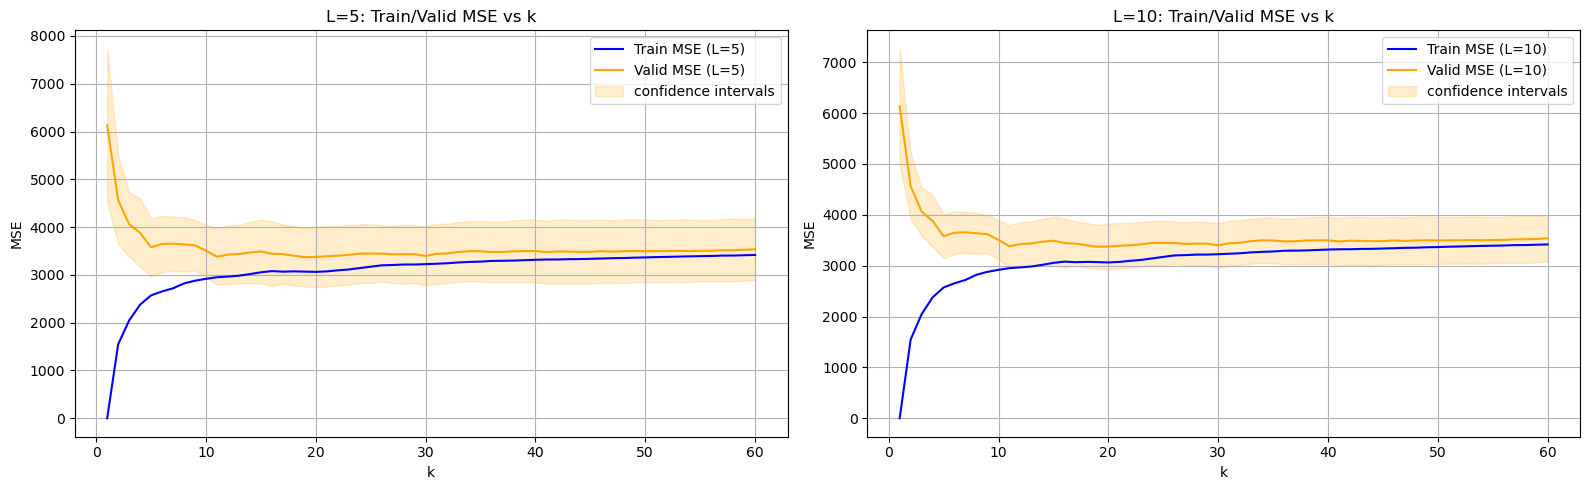

In [657]:
import matplotlib.pyplot as plt

k_values = np.arange(1, max_k + 1)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# L=5
axes[0].plot(k_values, results_l5["train_mse_means"], label="Train MSE (L=5)", color="blue")
axes[0].plot(k_values, results_l5["valid_mse_means"], label="Valid MSE (L=5)", color="orange")
axes[0].fill_between(
    k_values,
    results_l5["ci_lowers"],
    results_l5["ci_uppers"],
    color="orange",
    alpha=0.2,
    label="confidence intervals"
)
axes[0].set_xlabel("k")
axes[0].set_ylabel("MSE")
axes[0].set_title("L=5: Train/Valid MSE vs k")
axes[0].legend()
axes[0].grid(True)

# L=10
axes[1].plot(k_values, results_l10["train_mse_means"], label="Train MSE (L=10)", color="blue")
axes[1].plot(k_values, results_l10["valid_mse_means"], label="Valid MSE (L=10)", color="orange")
axes[1].fill_between(
    k_values,
    results_l10["ci_lowers"],
    results_l10["ci_uppers"],
    color="orange",
    alpha=0.2,
    label="confidence intervals"
)
axes[1].set_xlabel("k")
axes[1].set_ylabel("MSE")
axes[1].set_title("L=10: Train/Valid MSE vs k")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


#### Analysis
From the plots, we observe that very small values of $k$ (e.g., 1–3) lead to extremely low training errors but high validation errors, indicating overfitting. When $k$ increases to around 15–25, the validation error reaches its minimum, which can be regarded as the optimal region. For large $k$ values (>30), both training and validation errors increase, and the model suffers from underfitting.

Comparing $L$=5 and $L$=10, both curves show similar trends, but the confidence intervals are wider for $L$=5, implying higher variance in the error estimates. In contrast, $L$=10 produces narrower confidence intervals and thus more stable performance estimates, at the cost of higher computational effort. Given the dataset size (309 training samples), $L$=10 provides a more reliable choice.

## 3 Question 3 Automatic Model Selection

In [658]:
from sklearn.base import BaseEstimator
class KnnRegressorCV(BaseEstimator):
    def __init__(self, ks=list(range(1, 21)), cv=LFold(5)):
        self.ks = ks
        self.cv = cv
        self.k_ = None # the best k
        self.model_ = None # the best model
        
    def fit(self, x, y):
        best_k = None
        best_score = float('inf')
        
        # iterate over each k
        for k in self.ks:
            val_errors = []
            for train_idx, val_idx in self.cv.split(X_train):
                # split data
                X_tr, y_tr = X_train[train_idx], y_train[train_idx]
                X_val, y_val = X_train[val_idx], y_train[val_idx]
                
                knn = KnnRegressor(k=k)
                knn.fit(X_tr, y_tr)
                y_val_pred = knn.predict(X_val)
                val_mse = mse(y_val, y_val_pred)
                val_errors.append(val_mse)
                
            mean_error = np.mean(val_errors)
            if mean_error < best_score:
                best_score = mean_error
                best_k = k
        
        # record the best k and the model
        self.k_ = int(best_k)
        self.model_ = KnnRegressor(k=self.k_).fit(X_train, y_train)
        return self
    
    def predict(self, x):
        return self.model_.predict(x)

In [659]:
l_fold = LFold(L=10)
knn_cv = KnnRegressorCV(ks=list(range(1, 21)), cv=l_fold)
knn_cv.fit(X_train, y_train)
knn_cv.predict(X_test)
print("Chosen k by inner CV:", knn_cv.k_)


Chosen k by inner CV: 19


In [661]:
outer_cv = LFold(L=10)
inner_cv = LFold(L=10)

chosen_ks, test_mses = [], []
fold_count = 0
for tr_idx, val_idx in outer_cv.split(X_train):
    X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
    X_val, y_val = X_train[val_idx], y_train[val_idx]

    knn = KnnRegressorCV(ks=list(range(1,61)), cv=inner_cv).fit(X_tr, y_tr)
    chosen_ks.append(knn.k_)
    y_pred = knn.predict(X_val)
    test_mses.append(mse(y_val, y_pred))
    fold_count += 1
    print(f"Fold {fold_count} completed, Best k: {knn.k_}, Test MSE: {test_mses[-1]:.4f}")


Fold 1 completed, Best k: 19, Test MSE: 3051.8090
Fold 2 completed, Best k: 19, Test MSE: 3343.1868
Fold 3 completed, Best k: 19, Test MSE: 3030.7154
Fold 4 completed, Best k: 19, Test MSE: 3400.5805
Fold 5 completed, Best k: 19, Test MSE: 3421.9427
Fold 6 completed, Best k: 19, Test MSE: 4277.6495
Fold 7 completed, Best k: 19, Test MSE: 2809.0616
Fold 8 completed, Best k: 19, Test MSE: 3275.7413
Fold 9 completed, Best k: 19, Test MSE: 2095.4463
Fold 10 completed, Best k: 19, Test MSE: 2197.8804


# Analysis TODO